In [75]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from nltk import FreqDist, pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

## EDA 

In [119]:
pwd

'/Users/emilynaftalin/Data_Science/General Assembly/dsi/projects/project_3/code'

In [188]:
country = pd.read_pickle('../datasets/country_token_pickle.pkl')
rock = pd.read_pickle('../datasets/rock_token_pickle.pkl')

In [225]:
country.head()

,label,merged,tokens
0,country,country suggestions ve been starting to get in...,"[country, suggestions, ve, been, starting, to,..."
1,country,hank williams sr m so lonesome could cry (1949),"[hank, williams, sr, m, so, lonesome, could, c..."
2,country,cody jinks loud and heavy,"[cody, jinks, loud, and, heavy]"
3,country,"southern raised performs ""what day that will b...","[southern, raised, performs, what, day, that, ..."
4,country,is anybody still making texas swing? my father...,"[is, anybody, still, making, texas, swing, my,..."


In [193]:
rock.tail()

,label,merged,tokens
2995,rock,eddie van halen guitar legend and rock god di...,"[eddie, van, halen, guitar, legend, and, rock,..."
2996,rock,"r p rest in peace eddie, there were very few ...","[r, p, rest, in, peace, eddie, there, were, ve..."
2997,rock,rip eddie van halen,"[rip, eddie, van, halen]"
2998,rock,eddie van halen dies at 65 of cancer,"[eddie, van, halen, dies, at, 65, of, cancer]"
2999,rock,van halen everybody wants some!!,"[van, halen, everybody, wants, some]"


#### Inspecting common words and posts lengths in separate dataframes

_Note: I crafted my custom list of stop words after doing initial EDA that revealed the most frequently-used words in both of the subreddits. This EDA included fitting a `CountVectorizer` on the corpuses of both dataframes and then sorting by word frequency. I chose to remove words that are most common in one or both of the subreddits because, while some of them might help improve accuracy, they weaken the storyline and impair the ability of models to detect important words and features by drawing heavy attention to themselves and thereby skewing coefficients and feature importance distribution. I removed "ve" and "don" because my pre-processing created these from contracted words, and they ended up showing up very frequently. In the future I would modify my pre-processing to fix this problem, but I ran out of time to do so._

_Citation: Thank you Heather Johansen for helping figure out how to include my own custom list of words alongside the English stop words._

In [194]:
country_rock_stop_words = ['country', 'countries', 'rock', 'roll', 'just','song', 'songs', 'music', 
                           'album', 'band', 'bands', 'artist', 'artists', 've', 'don']
all_stop_words = text.ENGLISH_STOP_WORDS.union(country_rock_stop_words)

In [253]:
def vectorize_and_plot(df, text_field, color):
    cvec = CountVectorizer(stop_words=all_stop_words)
    col = df[text_field]
    cvec.fit(col)
    col = cvec.transform(col)
    plot_df = pd.DataFrame(col.todense(),
                          columns=cvec.get_feature_names())
    plot_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', align='center', alpha=0.5, color=color);
    


Text(0.5, 0, 'Frequency')

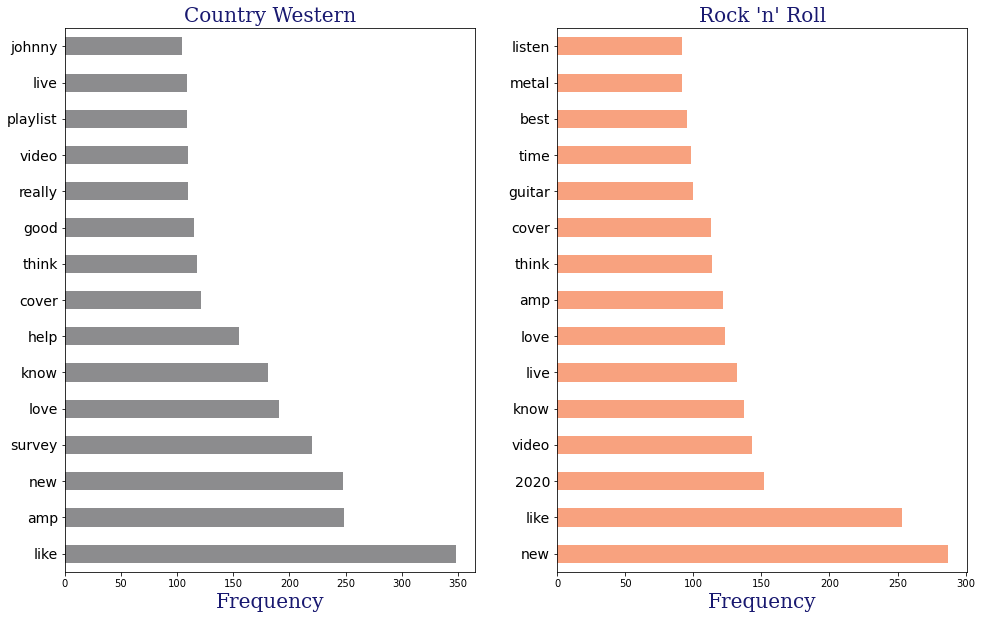

In [257]:
font = {'family': 'serif',
        'color':  'midnightblue',
        'weight': 'normal',
        'size': 20,
        }

plt.figure(figsize=(25, 10))

plt.subplot(131)
vectorize_and_plot(country, 'merged', '#1a1b1e')
plt.title('Country Western', fontdict=font)
plt.yticks(fontsize=14)
plt.xlabel('Frequency', fontdict=font)

plt.subplot(132)
vectorize_and_plot(rock, 'merged', '#f24600')
plt.title("Rock 'n' Roll", fontdict=font)
plt.yticks(fontsize=14)
plt.xlabel('Frequency', fontdict=font)

In [255]:
# import seaborn as sns

# cvec_c = CountVectorizer(stop_words=all_stop_words)
# col_c = country['merged']
# cvec_c.fit(col_c)
# col_c = cvec_c.transform(col_c)
# df_c = pd.DataFrame(col_c.todense(),
#                    columns=cvec_c.get_feature_names())

# ax = sns.barplot((df_c).sum().sort_values(ascending=False).head(20))

In [197]:
# code inspired by Emmanuel 
# line of code for extracting name from DataFrame to print it and use it as plot title is from this stack overflow page: 
# https://stackoverflow.com/questions/54137694/how-to-print-dataframe-name-in-title-of-a-plot

def post_length_distribution(df):
    
    #getting size of vocabulary 
    all_words = [word for tokens in df['tokens'] for word in tokens]    # getting all the words in the posts
    post_lengths = [len(tokens) for tokens in df['tokens']]    # getting length of the all the posts
    vocab = sorted(list(set(all_words)))    # getting the list of unique words in the corpus composed of the subreddit posts
    
    df_name = [x for x in globals() if globals()[x] is df][0]
    print(f'Post Lengths for {df_name.capitalize()} dataset:')
    
    print(f'{len(all_words)} words total, with a vocabulary size of {len(vocab)}')
    print(f'Max post length is {max(post_lengths)} words')
    print(f'Average post length is {np.mean(post_lengths).round(2)} words') 
    
    # plotting distribution 
    fig = plt.figure(figsize=(6,6))
    plt.xlabel('Post Length')
    plt.ylabel('Number of Posts')
    plt.title(df_name.capitalize())
    plt.hist(post_lengths, bins=50, range=[0, 100])
    plt.show()

Post Lengths for Country dataset:
58179 words total, with a vocabulary size of 6979
Max post length is 802 words
Average post length is 19.39 words


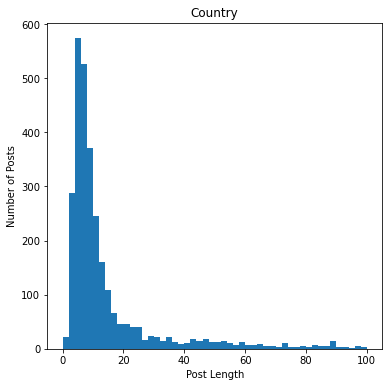

In [198]:
post_length_distribution(country)

Post Lengths for Rock dataset:
49047 words total, with a vocabulary size of 7848
Max post length is 935 words
Average post length is 16.35 words


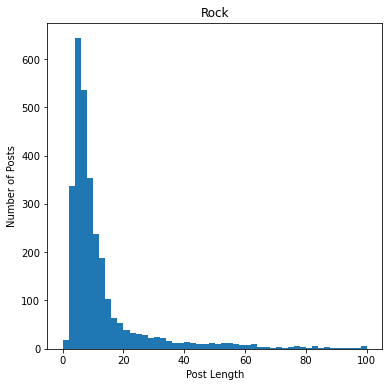

In [199]:
post_length_distribution(rock)

## **ADD COMMENTARY HERE ON POST LENGHTH DISTRIBUTION**

#### Removing long and short posts 

Below function will remove the longest and shortest posts from a dataframe since having a disproportionate number of words come from the same person/post might add unnecessary redundancy that does not reflect the entire corpus. 

**Longest posts:** 

`df['tokens'].map(lambda x: len(x)).nlargest(10)` 

**Shortest posts:**

`df['tokens'].map(lambda x: len(x)).nsmallest(20)`

    or:
   
`df[df['tokens'].str.split().str.len() < 5`


_Inspect results from longest and shortest posts functions above._ 

+ If one or more posts appears to be longer by multiple times or orders of magnitude, remove the row containing that post using the index numbers displayed.  

```
df.drop([idx], inplace=True)
```


+ Remove very short posts as follows: 

```
df = df[df['tokens'].str.split().str.len() > 5]
```


+ Rerun `post_length_distribution` function following this process to see how distribution has changed.  

In [200]:
country['tokens'].map(lambda x: len(x)).nlargest(10)

1473    802
443     789
2435    522
364     380
2648    374
1177    263
802     262
1252    261
1271    261
1328    261
Name: tokens, dtype: int64

In [201]:
# country.drop([1473, 443], inplace=True)

In [202]:
rock['tokens'].map(lambda x: len(x)).nlargest(10)

325     935
2925    870
827     787
1427    770
218     664
812     658
2710    530
303     491
445     303
1716    298
Name: tokens, dtype: int64

_Note! Rock music posts appear to be much longer. I will still drop all those that are longer than 5000 words as I did with the country music dataframe. This will create a more balanced combined dataset for modeling._

In [203]:
rock['tokens'].map(lambda x: len(x)).mean()

16.349

In [204]:
# rock.drop([325, 2925, 827, 1427, 812, 218], inplace=True)

_Since no posts are exhorbitantly long, I don't think that they will distort the analysis as an extremly post would. Therefore, I will not drop any posts based on length-- long or short -- from my dataframe._

## Model Prep 

#### Combining DataFrames 

don't forget null model! 

In [205]:
# def model_df(subreddit_1, subreddit_2):
    
#     model_df = pd.concat([subreddit_1, subreddit_2])
    
#     # resetting index
#     model_df.reset_index(drop=True, inplace=True)
    
#     model_df['label'] = model_df['label'].map({subreddit_1: 0, subreddit_2: 1})
    
#     # save concatenated datadframe to csv file 
#     filename = 'subreddit_1' + '_' + 'subredit_2' + '.csv'
#     model_df.to_csv('../datasets/' + filename, index=False)
    
#     return model_df 

## ^^^ This doesn't work beause dataframe can't be hashed ala the map function 

**Steps to build dataframe and prep for modeling:**

_Naming convention for new combined dataframe will be `subreddit1_subreddit2`, but is referenced in these instructions as `df`._

1. Combine separate datasets into on dataframe using this line of code: 

```python
df = pd.concat([subreddit_1, subreddit_2])
```

2. Reset index: 

```python
df.reset_index(drop=True, inplace=True)
```

3. Changes labels to binary numeric labels:

```python
df['label'] = df['label'].map({subreddit1: 0, subreddit2: 1})
```

3. Save concatenated dataframe to csv file:

```python 
filename = 'subreddit_1' + '_' + 'subredit_2' + '.csv'
df.to_csv('../datasets/' + filename, index=False)
```

In [206]:
# concantenating country music and rock music dataframes 
# Country music will be label 0
# Rock music will be label 1

country_rock = pd.concat([country, rock])

country_rock.reset_index(drop=True, inplace=True) 

country_rock['label']  = country_rock['label'].map({'country': 0, 'rock': 1})

In [207]:
# checking how it looks! 
country_rock

,label,merged,tokens
0,0,country suggestions ve been starting to get in...,"[country, suggestions, ve, been, starting, to,..."
1,0,hank williams sr m so lonesome could cry (1949),"[hank, williams, sr, m, so, lonesome, could, c..."
2,0,cody jinks loud and heavy,"[cody, jinks, loud, and, heavy]"
3,0,"southern raised performs ""what day that will b...","[southern, raised, performs, what, day, that, ..."
4,0,is anybody still making texas swing? my father...,"[is, anybody, still, making, texas, swing, my,..."
...,...,...,...
5995,1,eddie van halen guitar legend and rock god di...,"[eddie, van, halen, guitar, legend, and, rock,..."
5996,1,"r p rest in peace eddie, there were very few ...","[r, p, rest, in, peace, eddie, there, were, ve..."
5997,1,rip eddie van halen,"[rip, eddie, van, halen]"
5998,1,eddie van halen dies at 65 of cancer,"[eddie, van, halen, dies, at, 65, of, cancer]"


In [208]:
country_rock.shape

(6000, 3)

In [217]:
country_rock['label'].value_counts()

1    3000
0    3000
Name: label, dtype: int64

In [218]:
country_rock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   6000 non-null   int64 
 1   merged  6000 non-null   object
 2   tokens  6000 non-null   object
dtypes: int64(1), object(2)
memory usage: 140.8+ KB


In [219]:
country_rock.isnull().sum()

label     0
merged    0
tokens    0
dtype: int64

In [220]:
country_rock.head()

,label,merged,tokens
0,0,country suggestions ve been starting to get in...,"[country, suggestions, ve, been, starting, to,..."
1,0,hank williams sr m so lonesome could cry (1949),"[hank, williams, sr, m, so, lonesome, could, c..."
2,0,cody jinks loud and heavy,"[cody, jinks, loud, and, heavy]"
3,0,"southern raised performs ""what day that will b...","[southern, raised, performs, what, day, that, ..."
4,0,is anybody still making texas swing? my father...,"[is, anybody, still, making, texas, swing, my,..."


In [221]:
country_rock.tail()

,label,merged,tokens
5995,1,eddie van halen guitar legend and rock god di...,"[eddie, van, halen, guitar, legend, and, rock,..."
5996,1,"r p rest in peace eddie, there were very few ...","[r, p, rest, in, peace, eddie, there, were, ve..."
5997,1,rip eddie van halen,"[rip, eddie, van, halen]"
5998,1,eddie van halen dies at 65 of cancer,"[eddie, van, halen, dies, at, 65, of, cancer]"
5999,1,van halen everybody wants some!!,"[van, halen, everybody, wants, some]"


**Saving combined dataframe to csv file for use in models.**

In [72]:
country_rock.to_csv('../datasets/country_rock.csv', index=False)

**Pickle combined dataframe for use in modeling**

In [222]:
country_rock.to_pickle('../datasets/country_rock.pkl')

## Add note here about how I originally saved to csv then went back because it was all messed up and decided to pickle